# Prediction of pm-2.5 levels
The Aim of this notebook is to create a model to predict the pollution levels (pm 2.5) in China. To do so two alternative models will be compared: the  prophet model developed by meta for time series analysis, and an ensemble of multiple ML algortihms

## Dataset
The dataset is a multivariate time-series that includes, along with the pollution levels (pm-2.5), other features such as:
<center>

| **Feature**  | **Description**                                               |
|--------------|---------------------------------------------------------------|
| year, month, day, hour | Timing information.                                 |
| DEWP         | Dew Point indicator measured in Celsius degrees.              |
| TEMP         | Temperature measured in Celsius degrees.                      |
| PRES         | Atmospheric Pressure.                                         |
| cbwd         | Combined wind direction.                                      |
| Iws          | Cumulated wind speed (m/s).                                   |
| Is           | Cumulated hours of snow.                                      |
| Ir           | Cumulated hours of rain.                                      
|</center>
..

The dataset is composed of more than 43.000 observations. For this analysis, the first 10.000 will be used to train the models singularly while the second 10.000 will be used for the evaluation of the out of sample performances and to find the optimal linear ensemble of the models. The remaining observations will be used for the out of sample evaluation oftwothree models and their ensemble. The mean square error (MSE) is used to train the models and compare them. A

In [4]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularPredictor
from scipy.optimize import minimize

# Load data
data = pd.read_csv(r"C:\Users\PC-NB\Desktop\ML short\individual projects\PRSA_data_2010.1.1-2014.12.31.csv")
data = data.ffill()
data.index = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data = data.rename(columns={'pm2.5': 'y'})

data

C:\Users\PC-NB\anaconda3\envs\new-env-name\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,No,year,month,day,hour,y,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01 00:00:00,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
2014-12-31 22:00:00,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


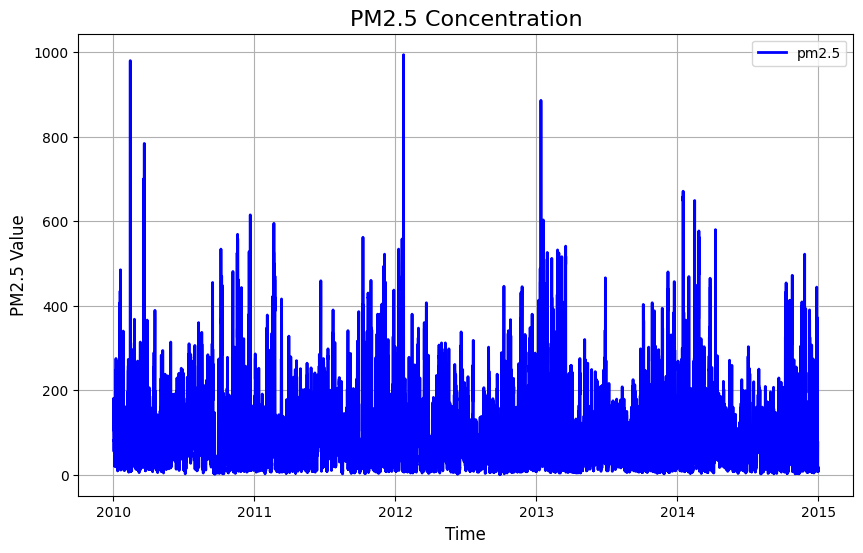

In [5]:
# Initial plot of the target variable.
plt.figure(figsize=(10, 6))
plt.plot(data["y"], color='blue', linewidth=2, label='pm2.5')
plt.title('PM2.5 Concentration', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('PM2.5 Value', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

### Feature engeneering
Between the Features, the lagged values of pollution are not considered. Even though the graphs shows little persistency with very high spikes, it is reasonable to include at least 3 lagged values. Since the dataset was initially reduced, including lags will not reduce the number of observations in the train set.

In [229]:
# Add lagged values to the dataframe
data['lag_1'] = data['y'].shift(1)
data['lag_2'] = data['y'].shift(2)
data['lag_3'] = data['y'].shift(3)

# The first 24 observations of pm2.5 are NaN so the first 27 rows will be dropped (because of the 3 lags introduced).
data = data.iloc[27:]

data_set_1 = data.iloc[0:10000].copy()
data_set_2 = data.iloc[10001:20000].copy()
data_set_3 = data.iloc[20001:].copy()

### Target encoding
The categorical variables together with month, day, and hour are target encoded to avoid dimensionality issues. Finally, the three sets are divided.

In [9]:
# Target encoding.
cbwd_mean = data_set_1.groupby("cbwd")["y"].mean().reset_index().rename(columns={"y": "cbwd_TE"})
data = data.merge(cbwd_mean, how="left", on="cbwd")

Ir_mean = data_set_1.groupby("Ir")["y"].mean().reset_index().rename(columns={"y": "Ir_TE"})
data = data.merge(Ir_mean, how="left", on="Ir")

hour_mean = data_set_1.groupby("hour")["y"].mean().reset_index().rename(columns={"y": "hour_TE"})
data = data.merge(hour_mean, how="left", on="hour")

date_mean = data_set_1.groupby(["day", "month"])["y"].mean().reset_index().rename(columns={"y": "date_TE"})
data = data.merge(date_mean, how="left", on=["day", "month"])

# The 29th of february appears only once so it will be interpolated
data = data.ffill()

data.index = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data = data.drop(['cbwd', 'Ir', "hour", "month", "day"], axis=1)

data_set_1 = data.iloc[0:10000].copy()
data_set_2 = data.iloc[10001:20000].copy()
data_set_3 = data.iloc[20001:].copy()

## Prophet model

12:46:58 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model MSE: 1107.8597426939916


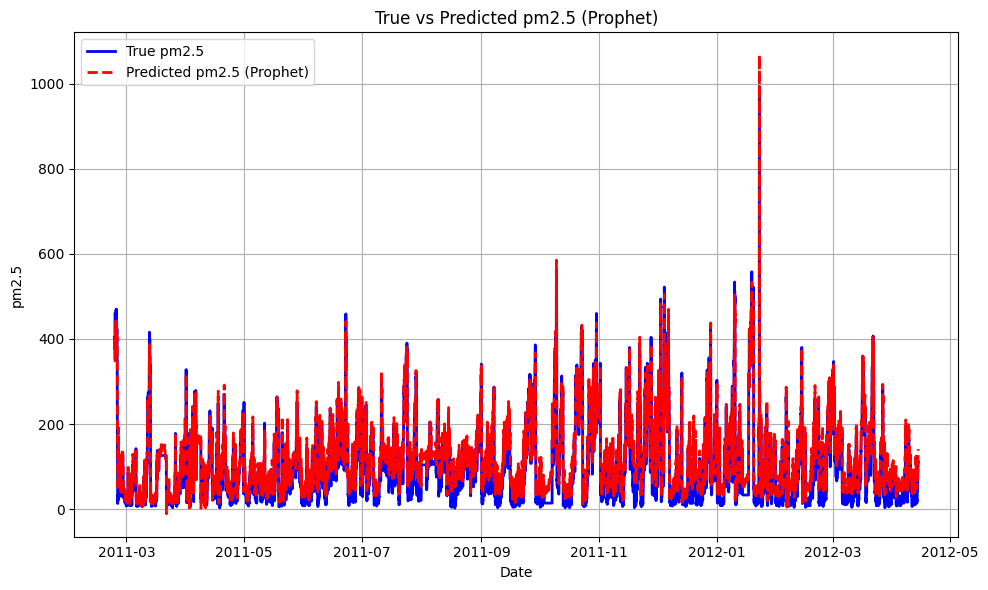

In [11]:
data_set_1['ds'] = data_set_1.index  

model_prophet = Prophet()
for regressor in ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'lag_1', 'lag_2', 'lag_3', 'cbwd_TE', 'Ir_TE', 'hour_TE', 'date_TE']:
    model_prophet.add_regressor(regressor)
model_prophet.fit(data_set_1[['ds', 'y', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'lag_1', 'lag_2', 'lag_3', 'cbwd_TE', 'Ir_TE', 'hour_TE', 'date_TE']])
data_set_2['ds'] = data_set_2.index  
forecast = model_prophet.predict(data_set_2[['ds', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'lag_1', 'lag_2', 'lag_3', 'cbwd_TE', 'Ir_TE', 'hour_TE', 'date_TE']])
mse_prophet = mean_squared_error(data_set_2['y'], forecast['yhat'])
print(f"Prophet Model MSE: {mse_prophet}")

# Actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data_set_2['ds'], data_set_2['y'], label='True pm2.5', color='blue', linewidth=2)
plt.plot(data_set_2['ds'], forecast['yhat'], label='Predicted pm2.5 (Prophet)', color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('pm2.5')
plt.title('True vs Predicted pm2.5 (Prophet)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

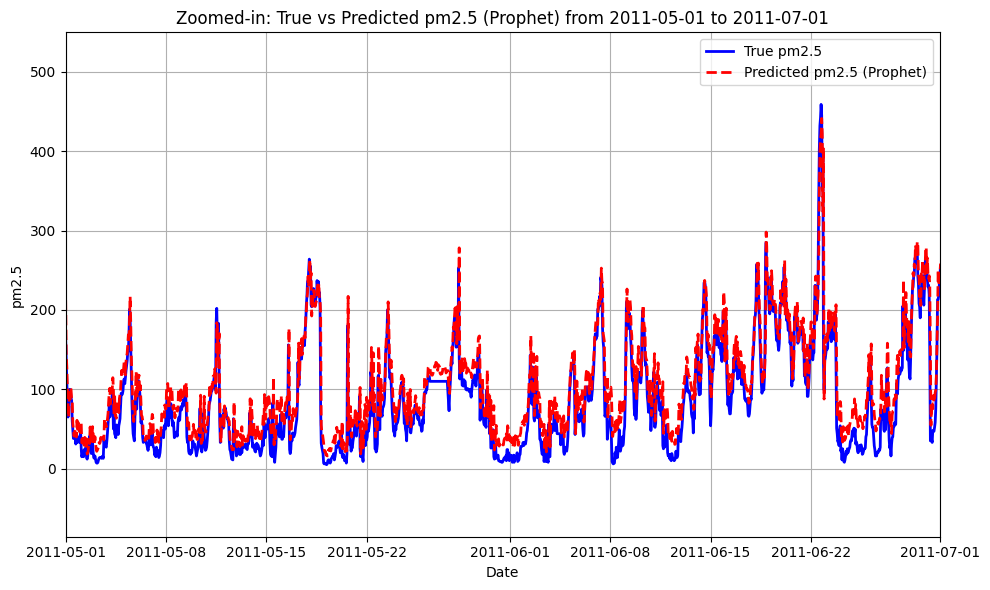

In [42]:
def plot_predictions(data, true_values, predicted_values, model_name, start_date=None, end_date=None, x_col='ds'):
    plt.figure(figsize=(10, 6))
    
    # Convert predicted_values to a pandas Series with same index as true_values
    predicted_values_series = pd.Series(predicted_values)
    predicted_values_series.index = true_values.index
    
    # Plot true values and predictions
    plt.plot(data[x_col], true_values, label='True pm2.5', color='blue', linewidth=2)
    plt.plot(data[x_col], predicted_values_series, label=f'Predicted pm2.5 ({model_name})', color='red', linestyle='--', linewidth=2)
    
    # Set plot labels and title
    plt.xlabel('Date')
    plt.ylabel('pm2.5')
    plt.title(f'True vs Predicted pm2.5 ({model_name})')
    plt.legend()
    plt.grid(True)

    # Apply zoom-in if start_date and end_date are provided
    if start_date and end_date:
        mask = (data[x_col] >= pd.to_datetime(start_date)) & (data[x_col] <= pd.to_datetime(end_date))
        true_subset = true_values[mask]
        predicted_subset = predicted_values_series[mask]
        minimum = min(true_subset.min(), predicted_subset.min())
        maximum = max(true_subset.max(), predicted_subset.max())
        plt.ylim(minimum - 0.2 * (maximum - minimum), maximum + 0.2 * (maximum - minimum))
        plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
        plt.title(f'Zoomed-in: True vs Predicted pm2.5 ({model_name}) from {start_date} to {end_date}')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_predictions(data=data_set_2, true_values=data_set_2['y'], predicted_values=forecast['yhat'], 
                 model_name='Prophet', start_date='2011-05-01', end_date='2011-07-01')

## Machine Learning model
A corresponding machine learning model for the one-step-ahead predictions is built using Autogluon. The best model is a weighted ensemble between LightGBMLarge (weight of 0.292), NeuralNetTorch (weight of 0.208), KNeighborsDist (weight of 0.167), LightGBM (weight of 0.125), CatBoost (weight of 0.125), and NeuralNetFastAI (weight of 0.083). 

In [44]:
predictors = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'lag_1', 'lag_2', 'lag_3', 'cbwd_TE', 'Ir_TE', 'hour_TE', 'date_TE']
label_column = 'y'

train_data = data_set_1[predictors + [label_column]]

predictor = TabularPredictor(label=label_column, eval_metric='mse').fit(
    train_data,
    presets='medium_quality')

leaderboard = predictor.leaderboard(silent=True)
leaderboard

No path specified. Models will be saved in: "AutogluonModels\ag-20241020_105102"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          20
Memory Avail:       8.61 GB / 15.63 GB (55.1%)
Disk Space Avail:   854.19 GB / 952.74 GB (89.7%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20241020_105102"
Train Data Rows:    10000
Train Data Columns: 12
Label Column:       y
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (980.0, 1.0, 99.8398, 94.58287)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one 

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-450.967727,mean_squared_error,0.090277,92.718334,0.000000,0.067272,2,True,12
1,CatBoost,-476.487840,mean_squared_error,0.008528,2.681777,0.008528,2.681777,1,True,6
2,LightGBM,-477.196961,mean_squared_error,0.000000,0.519613,0.000000,0.519613,1,True,4
3,ExtraTreesMSE,-483.382680,mean_squared_error,0.047916,0.863759,0.047916,0.863759,1,True,7
4,NeuralNetFastAI,-493.994651,mean_squared_error,0.015805,16.833609,0.015805,16.833609,1,True,8
5,LightGBMLarge,-498.386156,mean_squared_error,0.015891,1.850214,0.015891,1.850214,1,True,11
6,XGBoost,-501.639005,mean_squared_error,0.000000,0.569492,0.000000,0.569492,1,True,9
7,LightGBMXT,-504.634941,mean_squared_error,0.000000,1.583390,0.000000,1.583390,1,True,3
8,NeuralNetTorch,-514.124748,mean_squared_error,0.016003,70.749185,0.016003,70.749185,1,True,10
9,RandomForestMSE,-526.030192,mean_squared_error,0.066703,1.965091,0.066703,1.965091,1,True,5


Even though the process shows a limited persistency, the most relevant variable is the lag of 1 period. Overall, all the variables used are statistically significant hence won't be removed.

In [46]:
predictor.feature_importance(data = data_set_1)

These features in provided data are not utilized by the predictor and will be ignored: ['No', 'year', 'ds']
Computing feature importance via permutation shuffling for 12 features using 5000 rows with 5 shuffle sets...
	24.71s	= Expected runtime (4.94s per shuffle set)
	16.99s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
lag_1,13639.107838,457.155635,1.512319e-07,5,14580.397608,12697.818067
date_TE,469.826663,30.141055,2.021552e-06,5,531.887512,407.765814
lag_2,279.546407,47.011090,9.246248e-05,5,376.342892,182.749923
lag_3,243.257481,44.482862,1.284009e-04,5,334.848309,151.666652
Iws,150.088824,32.477240,2.474377e-04,5,216.959909,83.217738
TEMP,125.030055,10.922593,6.918633e-06,5,147.519826,102.540285
DEWP,114.694739,13.048593,1.976078e-05,5,141.561973,87.827505
PRES,98.513226,12.899376,3.448374e-05,5,125.073220,71.953232
hour_TE,97.059375,15.532827,7.609335e-05,5,129.041680,65.077070
cbwd_TE,90.964186,11.780909,3.301900e-05,5,115.221241,66.707130


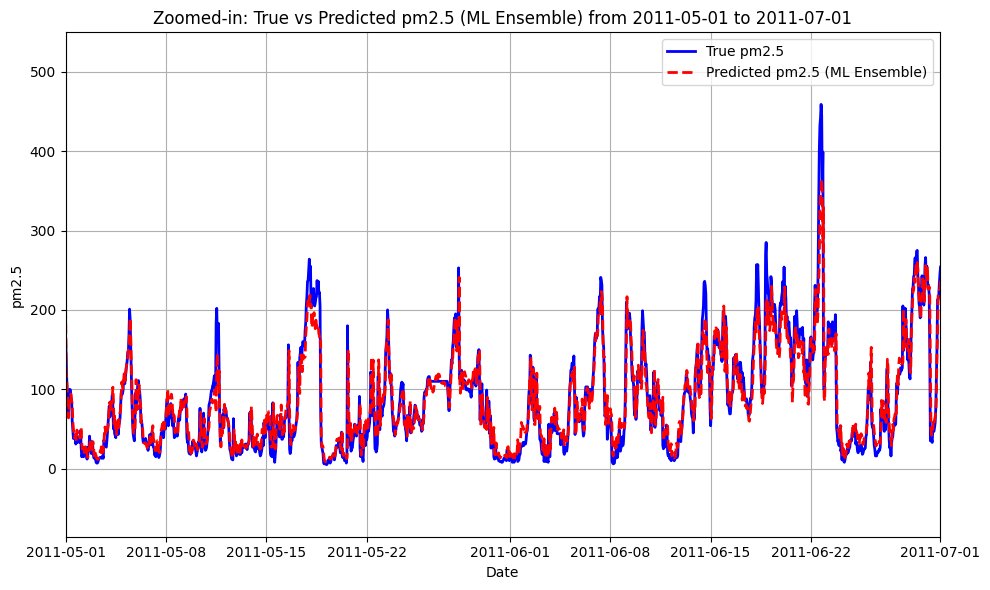

In [47]:
plot_predictions(data=data_set_2, true_values=data_set_2['y'], predicted_values=predictor.predict(data_set_2[predictors]), 
                 model_name='ML Ensemble', start_date='2011-05-01', end_date='2011-07-01')

The two following graphs plot the true values against the out of sample prediction of both the Prophet and ML alternative. 

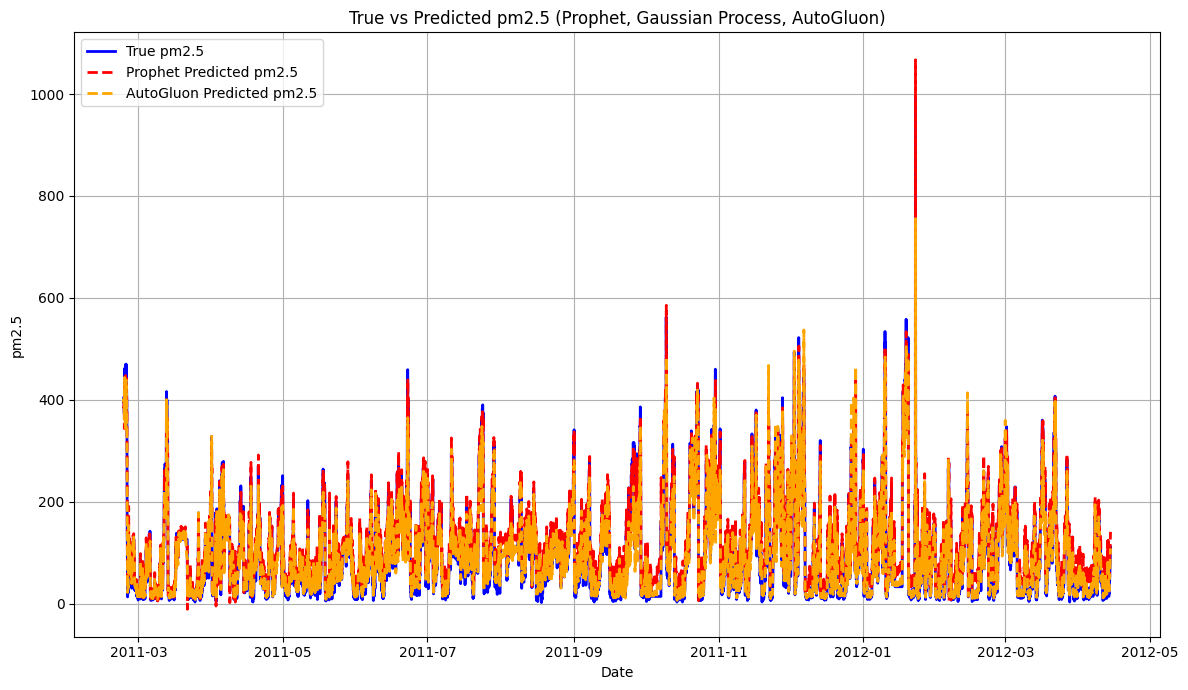

In [66]:
# Final Plot Comparing the alternative Models
def plot_all_models_comparison(start_date=None, end_date=None):
    plt.figure(figsize=(12, 7))

    # Plot true values
    plt.plot(data_set_2['ds'], data_set_2['y'], label='True pm2.5', color='blue', linewidth=2)

    # Prophet predictions
    plt.plot(data_set_2['ds'], forecast['yhat'], label='Prophet Predicted pm2.5', color='red', linestyle='--', linewidth=2)
    
    # AutoGluon predictions
    plt.plot(data_set_2['ds'], predictor.predict(data_set_2[predictors]), label='AutoGluon Predicted pm2.5', color='orange', linestyle='--', linewidth=2)
    
    plt.xlabel('Date')
    plt.ylabel('pm2.5')
    plt.title('True vs Predicted pm2.5 (Prophet, Gaussian Process, AutoGluon)')
    plt.legend()
    plt.grid(True)
    
    if start_date and end_date:
        plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
        plt.title(f'Zoomed-in: True vs Predicted pm2.5 from {start_date} to {end_date}')
    
    plt.tight_layout()
    plt.show()

# Example Usage for All Models Comparison
plot_all_models_comparison()

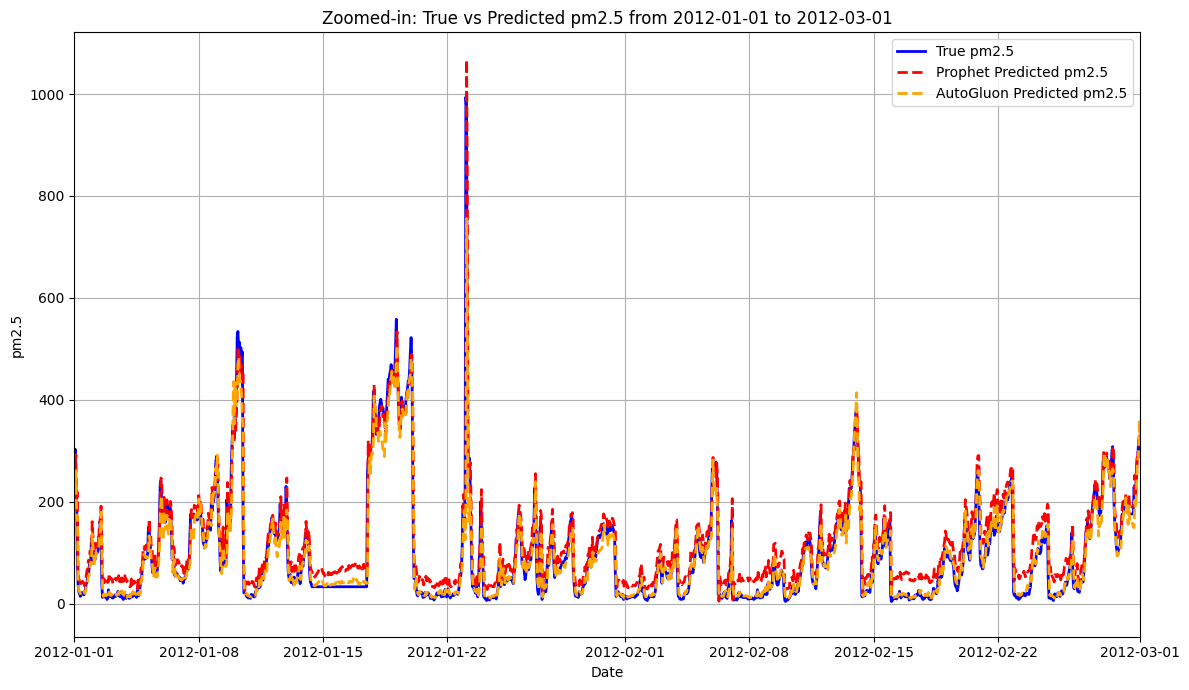

In [64]:
# Final Plot Comparing the alternative Models
plot_all_models_comparison(start_date='2012-01-01', end_date='2012-03-01')


## Final model
The two models trained using "data_set_1" will then be used to make the predictions on "data_set_2". Using these forecasts, a linear ensemble is created as to minimize the MSE of the ensemble with respect to the true values. Consider $y$ to be the real values of pm 2.5 observed in "data_set_2", $\hat{y}_{prophet}$ to be the prophet forecasts for $y$ and $\hat{y}_{ML}$ to be the ML forecasts for $y$. Then the coefficients are set as:
$$
\hat{\alpha}, \hat{\beta} = \underset{\alpha, \beta}{\operatorname{argmin}} \sum_{i=1}^n (y_i - \alpha\hat{y}_{i, prophet} - \beta\hat{y}_{i, ML})^2 \ subject \ to \ \alpha, \beta \in [0,1] \ and \ \alpha + \beta = 1
$$

The following chunk numerically solve this expression and return the out of sample MSE. the weights found are: for the prophet model and 0.7116 for the alternative. However, the out of sample MSE of the linear ensemble using these coefficients is worse than the MSE of the Autogluon model. This indicates that the performances of the prophet model keep getting worse as we move along the time axis.

In [221]:
# Create a new dataframe with true values and predictions from the three models
results_df = pd.DataFrame({
    'ds': data_set_2['ds'],
    'True Values': data_set_2['y']
})

# Add predictions from the three models
results_df["Prophet forecasts"] = forecast['yhat'].tolist()
results_df["ML forecasts"] = predictor.predict(data_set_2[predictors]).tolist() # ML prediction

def get_optimal_weights(df):
    """
    This function finds the optimal weights to combine 'ML forecasts' and 'Prophet forecasts'
    such that their linear combination minimizes the MSE with respect to 'True Values'.

    Args:
    df (pd.DataFrame): A dataframe containing 'True Values', 'ML forecasts', and 'Prophet forecasts'.

    Returns:
    optimal_weights (list): A list of the optimal weights for 'Prophet' and 'ML'.
    result.fun (float): The minimized MSE.
    """

    def objective_function(weights, X, y):
        weighted_pred = (weights[0] * X['Prophet forecasts'] +
                         weights[1] * X['ML forecasts'])
        return mean_squared_error(y, weighted_pred)

    X = df[['Prophet forecasts', 'ML forecasts']]
    y = df['True Values']
    
    # Initial weights (equal weights to start)
    initial_weights = [0.5, 0.5]
    
    # Constraints: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: 1 - sum(w)}
    
    # Bounds: weights should be between 0 and 1
    bounds = [(0, 1), (0, 1)]
    
    # Perform the optimization
    result = minimize(objective_function, initial_weights, args=(X, y), bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    minimized_mse = result.fun
    return optimal_weights, minimized_mse

# Apply the function to find optimal weights
optimal_weights, minimized_mse = get_optimal_weights(results_df)
print(f"Optimal weights:")
print(f"Prophet: {optimal_weights[0]:.4f}, ML: {optimal_weights[1]:.4f}")

# Create a dataframe with the forecasts
data_set_3['ds'] = data_set_3.index  
final_df = pd.DataFrame({"True Values": data_set_3["y"], 
                         "ML forecasts": predictor.predict(data_set_3[predictors]),
                         "Prophet forecasts": model_prophet.predict(data_set_3[['ds', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'lag_1', 'lag_2', 'lag_3', 'cbwd_TE', 'Ir_TE', 'hour_TE', 'date_TE']])["yhat"].tolist()
                        })
final_df["Ensemble forecasts"] = (optimal_weights[0] * final_df["Prophet forecasts"] + optimal_weights[1] * final_df["ML forecasts"]).tolist()

# Calculate MSE for each model and the ensemble on the test set
mse_prophet = mean_squared_error(final_df['True Values'], final_df['Prophet forecasts'])
mse_autogluon = mean_squared_error(final_df['True Values'], final_df['ML forecasts'])
mse_ensemble = mean_squared_error(final_df['True Values'], final_df['Ensemble forecasts'])

# Create a dataframe with the MSE values
mse_comparison = pd.DataFrame({
    'Model': ['Prophet', 'AutoGluon', 'Linear Ensemble'],
    'MSE': [mse_prophet, mse_autogluon, mse_ensemble]
})

mse_comparison

Optimal weights:
Prophet: 0.2884, ML: 0.7116


,Model,MSE
0,Prophet,5005.274437
1,AutoGluon,803.277199
2,Linear Ensemble,1008.213054


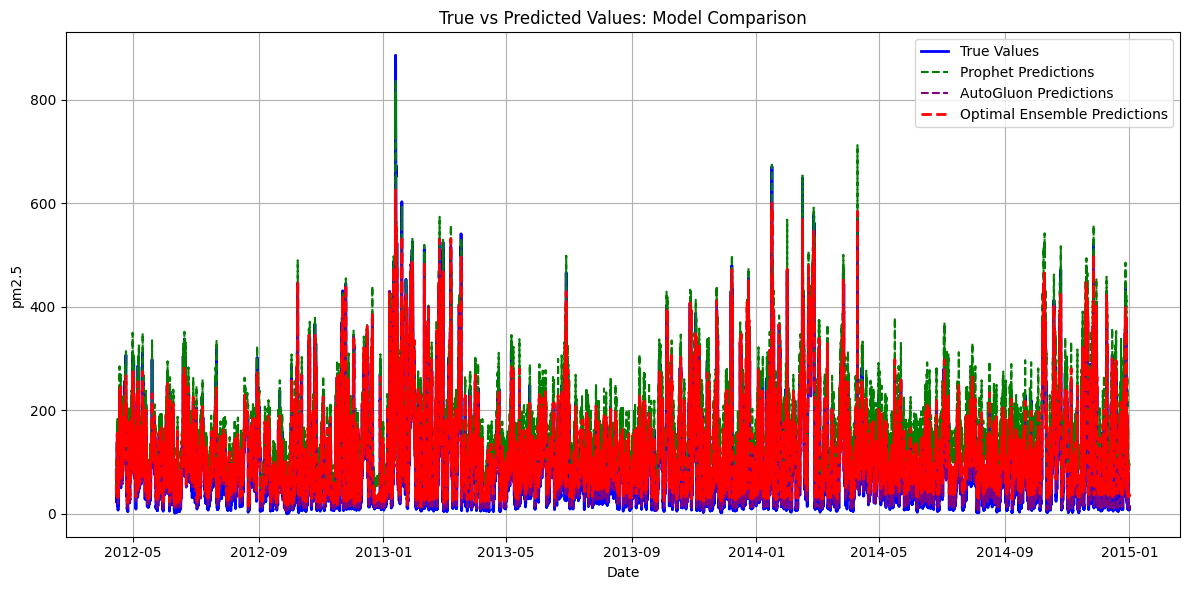

In [211]:
# Plot the comparison of actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['True Values'], label='True Values', color='blue', linewidth=2)
plt.plot(final_df.index, final_df['Prophet forecasts'], label='Prophet Predictions', color='green', linestyle='--')
plt.plot(final_df.index, final_df['ML forecasts'], label='AutoGluon Predictions', color='purple', linestyle='--')
plt.plot(final_df.index, final_df['Ensemble forecasts'], label='Optimal Ensemble Predictions', color='red', linestyle='--', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('pm2.5')
plt.title('True vs Predicted Values: Model Comparison')
plt.legend()

# Add grid and adjust layout
plt.grid(True)
plt.tight_layout()
plt.show()